In [19]:
import anndata as ad
import scanpy as sc
import gc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import scipy
import torch
import os

from scDisInFact import scdisinfact, create_scdisinfact_dataset

from metrics import calculate_metrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def run_scdisinfact(adata, batch_key, condition_key, dataset_name, cell_type_label=None):
    if np.max(adata.X) > 15:
        sc.pp.filter_cells(adata, min_genes=300)
        sc.pp.filter_genes(adata, min_cells=10)

        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)

    if adata.shape[1] > 3000:
        sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key=batch_key)
        adata = adata[:, adata.var["highly_variable"]].copy()
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=adata.shape[1], batch_key=batch_key)

    import warnings

    # Suppress all warnings
    warnings.filterwarnings("ignore")

    result_dir = "./scd/" + dataset_name + "/"
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    if isinstance(adata.X, scipy.sparse.spmatrix):
        adata.X = adata.X.toarray()

    counts = adata.X
    #print(counts[:10,:10])
    adata.obs["batch"] = adata.obs[batch_key].copy()
    meta_cells = adata.obs.copy()

    if isinstance(condition_key, str):
        condition_key = [condition_key]

    if not isinstance(condition_key, list):
        print("Wrong condition_key, must be string or list of string")

    data_dict = create_scdisinfact_dataset(counts, meta_cells, condition_key=condition_key, batch_key=batch_key, log_trans=False)

    # default setting of hyper-parameters
    reg_mmd_comm = 1e-4
    reg_mmd_diff = 1e-4
    reg_kl_comm = 1e-5
    reg_kl_diff = 1e-2
    reg_class = 1
    reg_gl = 1

    Ks = [8, 4]

    batch_size = 64
    nepochs = 100
    interval = 10
    lr = 5e-4
    lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]
    model = scdisinfact(data_dict=data_dict, Ks=Ks, batch_size=batch_size, interval=interval, lr=lr,
                        reg_mmd_comm=reg_mmd_comm, reg_mmd_diff=reg_mmd_diff, reg_gl=reg_gl, reg_class=reg_class,
                        reg_kl_comm=reg_kl_comm, reg_kl_diff=reg_kl_diff, seed=0, device=device)
    #model.train()
    #losses = model.train_model(nepochs=nepochs, recon_loss="NB")
    #torch.save(model.state_dict(), result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")
    model.load_state_dict(
        torch.load(result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth", map_location=device))
    _ = model.eval()

    # one forward pass
    z_cs = []
    z_ds = []
    zs = []

    for dataset in data_dict["datasets"]:
        with torch.no_grad():
            # pass through the encoders
            dict_inf = model.inference(counts=dataset.counts_norm.to(model.device),
                                       batch_ids=dataset.batch_id[:, None].to(model.device), print_stat=True)
            # pass through the decoder
            dict_gen = model.generative(z_c=dict_inf["mu_c"], z_d=dict_inf["mu_d"],
                                        batch_ids=dataset.batch_id[:, None].to(model.device))
            z_c = dict_inf["mu_c"]
            z_d = dict_inf["mu_d"]
            z = torch.cat([z_c] + z_d, dim=1)
            mu = dict_gen["mu"]
            z_ds.append([x.cpu().detach().numpy() for x in z_d])
            z_cs.append(z_c.cpu().detach().numpy())
            zs.append(np.concatenate([z_cs[-1]] + z_ds[-1], axis=1))

    latent = np.concatenate(z_cs, axis=0)
    print(latent)
    meta_dict = {}
    for namei in meta_cells.columns.tolist():
        meta_dict[namei] = np.concatenate([x[namei].values for x in data_dict["meta_cells"]])

    meta_df = pd.DataFrame(meta_dict)
    adata_latent = ad.AnnData(X=latent)
    #adata_latent.var_names = adata.var_names
    adata_latent.obs = meta_df

    adata_latent.obsm["X_pca"]=latent
    adata_latent.obsm['main_effect']=latent
    
    adata_latent.write_h5ad("./scd/" + dataset_name + "_effect_modifier_space.h5ad")
    '''sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    for colori in [cell_type_label, condition_key, batch_key]:
        sc.pl.umap(adata_latent, color=colori, ncols=1)'''
        
    return adata_latent

In [21]:
def evaluate_scd_comprehensive(adata, cell_type_label, batch_key, condition_key, dataset_name):
    cell_type_key=cell_type_label
    print(dataset_name, "adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata.raw = None
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"] = batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")

    #main_effect_adata = ad.AnnData(adata.obsm['main_effect'], dtype=np.float32)

    main_effect_adata = adata#ad.AnnData(adata.obsm['main_effect'], dtype=np.float32)
    #main_effect_adata.var_names = adata.var_names
    #main_effect_adata.obs = adata.obs.copy()

    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    else:
        main_effect_adata.obsm['X_pca'] = main_effect_adata.X.copy()
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(main_effect_adata, color=colori, ncols=1)

    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all_with_condition",
                      celltype_key=cell_type_key, all=True, n_neighbors=15,
                     savepath="./scd/" + dataset_name + "_main_effect.csv")
    print("-" * 20)

# ECCITE

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.
ECCITE adata preprocessing...
adata preprocessing...
batch_all ['rep1' 'rep2' 'rep3']
batch_all_with_condition ['rep1__NT' 'rep1__Perturbed' 'rep2__NT' 'rep2__Perturbed' 'rep3__NT'
 'rep3__Perturbed']


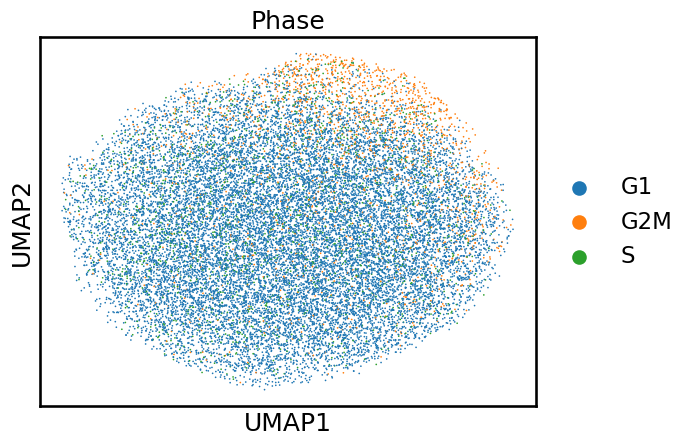

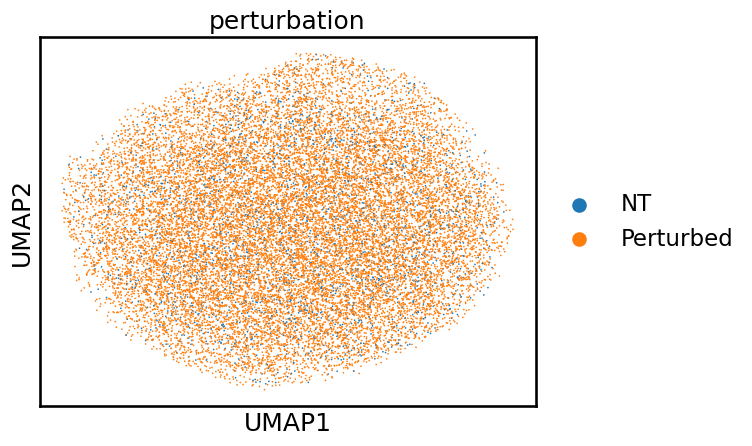

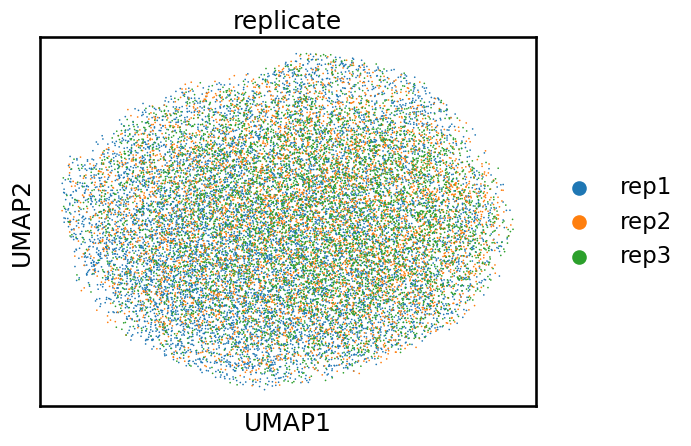

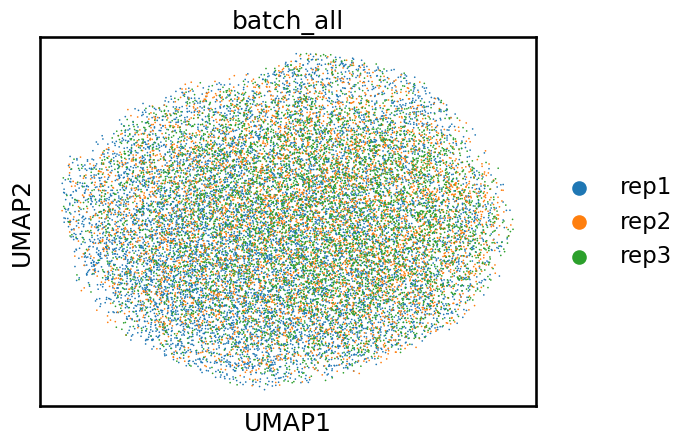

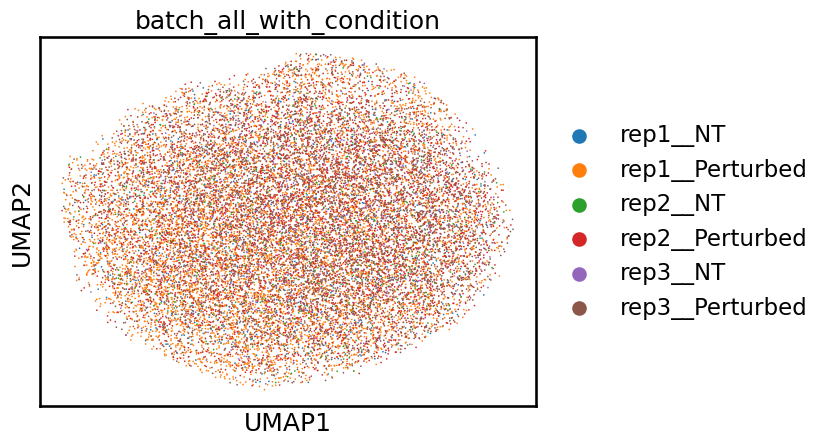

['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']
LISI---
cLISI, bLISI, LISI_F1 0.8171554014947225 0.39260137683431917 0.5303815468718459
ASW---
asw_label 0.5132284024730325
asw_batch 0.9536127694797267
kBET---
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
kbet_score 0.805271600008136
graph_conn 0.8118471488207945
NMI, ARI ---
NMI 0.054447052253948296
ARI 0.0250431356865109
positive and true positive rate---
       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.513228  0.025043  0.054447  0.817155  0.392601   0.953613   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.805272            0.811847  

In [4]:
adata=sc.read_h5ad("../data/ECCITE.h5ad")
adata_latent=run_scdisinfact(adata=adata, batch_key='replicate', condition_key='perturbation', cell_type_label="Phase", dataset_name="ECCITE")
evaluate_scd_comprehensive(adata=adata_latent, batch_key='replicate', condition_key='perturbation', cell_type_label="Phase", dataset_name="ECCITE")

# ASD

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.
[[-0.7672426   5.9604573  -1.4632717  ... -6.0132723   6.311168
   1.515391  ]
 [-0.14900735 -1.7511158  -0.03816149 ... -6.412194    8.460749
  -4.7296367 ]
 [-0.5913402   5.538473   -1.9686086  ... -4.7616715   3.2136877
   2.3149998 ]
 ...
 [ 1.6638432  -0.18734989  1.3559747  ... -7.0619917   3.5139449
   2.0460863 ]
 [ 2.7926486   1.5562878   2.2255688  ... -9.838106    4.1042204
   2.8440402 ]
 [ 3.0353231   0.553349    1.5884733  ... -5.541288    0.68732715
   1.7440606 ]]


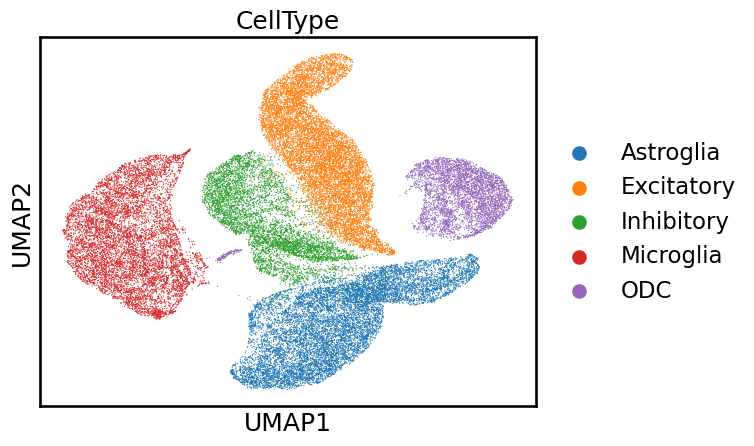

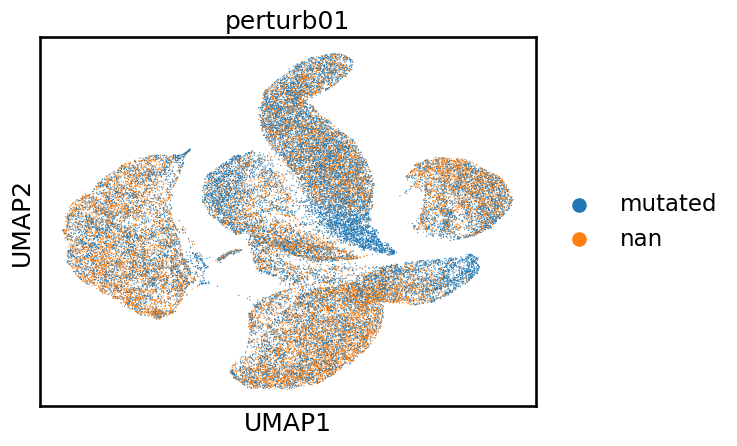

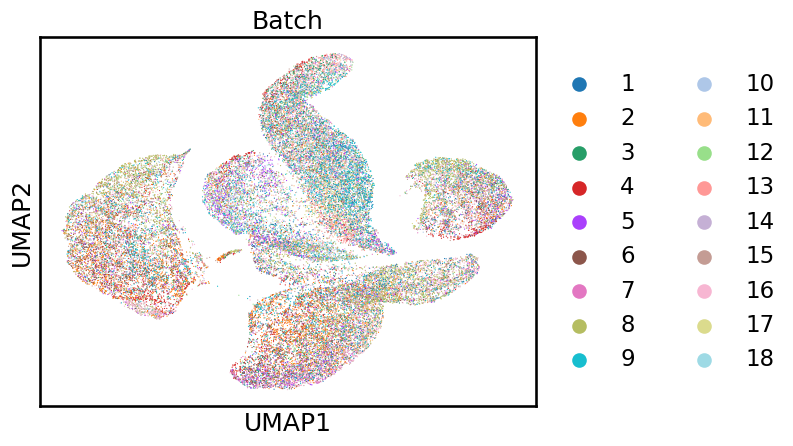

In [22]:
adata=sc.read_h5ad("../data/ASD1.h5ad")
adata_latent=run_scdisinfact(adata=adata, batch_key='Batch', condition_key='perturb01', cell_type_label="CellType", dataset_name="ASD1")
#evaluate_scd_comprehensive(adata=adata_latent, batch_key='Batch', condition_key='perturb01', cell_type_label="CellType", dataset_name="ASD1")